<a href="https://colab.research.google.com/github/Verose/ML_Applications_TAU/blob/master/Assignment_2_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import *
from sklearn.metrics import confusion_matrix

# Gender classification

In this assignment you will build a gender classifier for Twitter users, using the following dataset:

https://www.kaggle.com/crowdflower/twitter-user-gender-classification

For more info about the dataset please refer to the Kaggle page. Each row represents a single user on Twitter.
It contains the following fields:

The dataset contains the following fields:

**_unit_id**: a unique id for user

**_golden**: whether the user was included in the gold standard for the model; TRUE or FALSE

**_unit_state**: state of the observation; one of finalized (for contributor-judged) or golden (for gold standard observations)

**_trusted_judgments**: number of trusted judgments (int); always 3 for non-golden, and what may be a unique id for gold standard observations

**_last_judgment_at**: date and time of last contributor judgment; blank for gold standard observations

**gender**: one of male, female, or brand (for non-human profiles)

**gender:confidence**: a float representing confidence in the provided gender

**profile_yn**: "no" here seems to mean that the profile was meant to be part of the dataset but was not available when 
contributors went to judge it

**profile_yn:confidence**: confidence in the existence/non-existence of the profile

**created**: date and time when the profile was created

**description**: the user's profile description

**fav_number**: number of tweets the user has favorited

**gender_gold**: if the profile is golden, what is the gender?

**link_color**: the link color on the profile, as a hex value

**name**: the user's name

**profile_yn_gold**: whether the profile y/n value is golden

**profileimage**: a link to the profile image

**retweet_count**: number of times the user has retweeted (or possibly, been retweeted)

**sidebar_color**: color of the profile sidebar, as a hex value

**text**: text of a random one of the user's tweets

**tweet_coord**: if the user has location turned on, the coordinates as a string with the format "[latitude, longitude]"

**tweet_count**: number of tweets that the user has posted

**tweet_created**: when the random tweet (in the text column) was created

**tweet_id**: the tweet id of the random tweet

**tweet_location**: location of the tweet; seems to not be particularly normalized

**user_timezone**: the timezone of the user


So, the response variable is "gender". The features can be all the others.
Please ignore the 50 "golden" entries. They were probably labeled as golden for a specific experiment that was done by the dataset creator.

Please follow the insrtuctions, and fill in the missing part.

# Section 1: Data preparation

Here I connect my Kaggle account for downloading the dataset directly to my Colab machine. You can always do that like we did before. You can go to Kaggle manually, download the file, upload it into your drive, and mount your drive here.

In [0]:
# Install Kaggle API and connect it to your account 

# 1. Go to https://www.kaggle.com/barkfir/account    (note, replace my handle with yours)
# 2. Click on Create New API Token
# 3. It will download a new json file to your machine, which contains your key. Copy your username and key to the relevant locations below.

# !pip install -U -q kaggle
# !mkdir -p ~/.kaggle
# !echo '{"username":"","key":""}' > ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json

In [0]:
# TODO: Download the dataset from https://www.kaggle.com/crowdflower/twitter-user-gender-classification
# and put it in your drive

# !kaggle datasets download -d crowdflower/twitter-user-gender-classification -p data
# !unzip data/twitter-user-gender-classification.zip

In [0]:
# TODO: Load gender-classifier-DFE-791531.csv into "data" variable

from google.colab import drive

drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML course/data/gender-classifier-DFE-791531.csv', encoding="latin1")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
_unit_id                 20050 non-null int64
_golden                  20050 non-null bool
_unit_state              20050 non-null object
_trusted_judgments       20050 non-null int64
_last_judgment_at        20000 non-null object
gender                   19953 non-null object
gender:confidence        20024 non-null float64
profile_yn               20050 non-null object
profile_yn:confidence    20050 non-null float64
created                  20050 non-null object
description              16306 non-null object
fav_number               20050 non-null int64
gender_gold              50 non-null object
link_color               20050 non-null object
name                     20050 non-null object
profile_yn_gold          50 non-null object
profileimage             20050 non-null object
retweet_count            20050 non-null int64
sidebar_color            20050 non-null object
text    

In [0]:
# TODO: Drop the golden entries
data = data[data['_golden'] == False]
data = data.drop('_golden', 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 25 columns):
_unit_id                 20000 non-null int64
_unit_state              20000 non-null object
_trusted_judgments       20000 non-null int64
_last_judgment_at        20000 non-null object
gender                   19903 non-null object
gender:confidence        19974 non-null float64
profile_yn               20000 non-null object
profile_yn:confidence    20000 non-null float64
created                  20000 non-null object
description              16262 non-null object
fav_number               20000 non-null int64
gender_gold              0 non-null object
link_color               20000 non-null object
name                     20000 non-null object
profile_yn_gold          0 non-null object
profileimage             20000 non-null object
retweet_count            20000 non-null int64
sidebar_color            20000 non-null object
text                     20000 non-null object
tweet_co

In [0]:
# TODO: How many female/male/brand/unknown exist in the data?

data = data.dropna(subset=['gender'])  # drop rows with empty gender column
males = (data.gender == 'male').sum()
females = (data.gender == 'female').sum()
brand = (data.gender == 'brand').sum()
unknown = (data.gender == 'unknown').sum()
print('There are {} females, {} males, {} brand and {} unknown'.format(females, males, brand, unknown))

There are 6685 females, 6173 males, 5928 brand and 1117 unknown


In [0]:
# TODO: visualize link_color vs. gender
# In order to do that, you are required to:

# 1. convert link_color to RGB (array of 3 integers)
# 2. run Kmeans (clustering algorithm) for K clusters (try K=10) to cluster the colors
# 3. Visualize gender as stacked bar plot (see example in the assignment box)

# To run Kmeans - use sklearn.cluster.KMeans
# first, run:
# 
# kmeans = KMeans(n_clusters=10, random_state=0).fit(X)   # X is the dataset containing all RGB color values
# then, run:
#
# labels = kmeans.predict(X)
# to get the label (cluster) of each row

from sklearn.cluster import KMeans

# remove invalid link colors entries
data = data[data.link_color.str.len() == 6]

def hex2rgb(color):
  return (int(color[0:2], 16), int(color[2:4], 16), int(color[4:6], 16))
def rgb2hex(rgb):
  return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))

X = []
y = []
colors = []
for color, gender in zip(data.link_color, data.gender):
  X += [hex2rgb(color)]
  y += [gender]
  colors += [color]

X = np.array(X)
y = np.array(y)


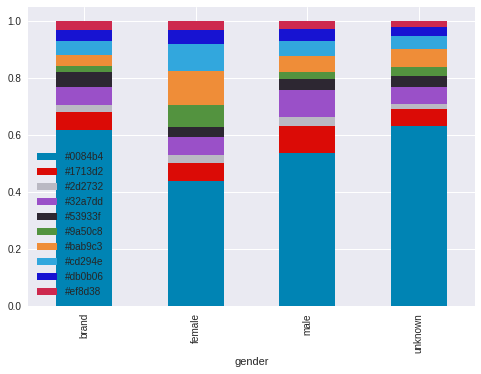

In [0]:
# visualize the data:
from collections import Counter


kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
y_predict = kmeans.predict(X)

# color map from cluster id to original color      
colors = []
for center in kmeans.cluster_centers_:
  rgb = int(center[0]), int(center[1]), int(center[2])
  colors.append(rgb2hex(rgb))

# visualize the data:
def get(cluster):
  temp = [gen for gen, clust in zip(y, y_predict) if clust == cluster]
  temp = Counter(temp)
  return (temp['brand'], temp['female'], temp['male'], temp['unknown'])


params = get(0), get(1), get(2), get(3), get(4), get(5), get(6), get(7), get(7), get(9)

# normalize the data to sum to 1
params_normalize = []
sum_i = []
for i in range(4):  # calculate max of each color
    sum_i += [sum([par[i] for par in params])]

for param in params:  # normalize
    params_normalize += [(param[0] / sum_i[0], param[1] / sum_i[1], param[2] / sum_i[2], param[3] / sum_i[3])]

bar = {
    colors[0]: params_normalize[0],
    colors[1]: params_normalize[1],
    colors[2]: params_normalize[2],
    colors[3]: params_normalize[3],
    colors[4]: params_normalize[4],
    colors[5]: params_normalize[5],
    colors[6]: params_normalize[6],
    colors[7]: params_normalize[7],
    colors[8]: params_normalize[8],
    colors[9]: params_normalize[9],
}

ind = np.arange(4)
width = 0.35

plt.clf()
index = pd.Index(('brand', 'female', 'male', 'unknown'), name='gender')
bar = pd.DataFrame(bar, index=index)
ax = bar.plot(kind='bar', stacked=True, color=colors)
plt.show()


In [0]:
# TODO: Divide the data to train and test, with test_size=0.2, random_state=0

# preprocess the data
data = data.drop(columns=['_unit_id', 'tweet_id', '_trusted_judgments', 'profile_yn:confidence', 'tweet_count',
                          'tweet_coord', 'gender:confidence'])
data = data[data["gender"] != "unknown"]
data = data[data.link_color.str.len() == 6]
data = data[data.sidebar_color.str.len() == 6]
y = data['gender']
X = data.drop('gender', 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [0]:
def print_scores(y_true, y_hat, stage="", mode=""):
  scores = precision_recall_fscore_support(y_true, y_hat, average='micro')
  print('DecisionTreeClassifier: {}: {}:\nPrecision: {} Recall: {} F score: {}'.format(stage, mode, *scores))
  
def add_feature_to_df(orig_df, column, v, fit=False):
  if fit:
    X_td = v.fit_transform(column)
  else:
    X_td = v.transform(column)

  df_ret = pd.DataFrame(X_td.toarray(), columns=v.get_feature_names())
  df_ret = df_ret.add_prefix('tf_idf-')
  df_ret = orig_df.reset_index(drop=True).join(df_ret.reset_index(drop=True), rsuffix='_r')
  return df_ret

# Section 2: Decision Tree

Use DecisionTreeClassifier to classify the data, using different feature sets.

In [0]:
# TODO: Use only numeric fields to classify the data for gender. 
# Report on micro-average of precision/recall/F Score.

from sklearn.metrics import precision_recall_fscore_support

X_train_numeric = X_train._get_numeric_data()
X_test_numeric = X_test._get_numeric_data()

model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train_numeric, y_train)
y_hat_train = model.predict(X_train_numeric)
y_hat_test = model.predict(X_test_numeric)
print_scores(y_train, y_hat_train, "numeric", "train")
print_scores(y_test, y_hat_test, "numeric", "test")

DecisionTreeClassifier: numeric: train:
Precision: 0.5250540735400144 Recall: 0.5250540735400144 F score: 0.5250540735400144
DecisionTreeClassifier: numeric: test:
Precision: 0.5165825522710887 Recall: 0.5165825522710887 F score: 0.5165825522710887


In [0]:
# TODO: Add the description attribute as a feature and classify the data for gender. 
# Make sure to transform the texts into numerical features using TF-IDF.
# Report on micro-average of precision/recall/F Score.

from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer(analyzer="word", lowercase=True)
X_train_desc = add_feature_to_df(X_train_numeric, X_train['description'].fillna(''), v, True)
X_test_desc = add_feature_to_df(X_test_numeric, X_test['description'].fillna(''), v)

model.fit(X_train_desc, y_train)
y_hat_train = model.predict(X_train_desc)
y_hat_test = model.predict(X_test_desc)
print_scores(y_train, y_hat_train, "description", "train")
print_scores(y_test, y_hat_test, "description", "test")


DecisionTreeClassifier: description: train:
Precision: 0.5453316510454218 Recall: 0.5453316510454218 F score: 0.5453316510454218
DecisionTreeClassifier: description: test:
Precision: 0.5367700072098054 Recall: 0.5367700072098054 F score: 0.5367700072098054


In [0]:
# TODO: Add the tweet attribute as a feature and classify the data for gender. 
# Make sure to transform the texts into numerical features using TF-IDF.
# Report on micro-average of precision/recall/F Score.

v = TfidfVectorizer(analyzer="word", min_df=10, lowercase=True, stop_words="english", ngram_range=(1, 5))
X_train_tweet = add_feature_to_df(X_train_desc, X_train['text'], v, True)
X_test_tweet = add_feature_to_df(X_test_desc, X_test['text'], v)

model.fit(X_train_tweet, y_train)
y_hat_train = model.predict(X_train_tweet)
y_hat_test = model.predict(X_test_tweet)
print_scores(y_train, y_hat_train, "tweet", "train")
print_scores(y_test, y_hat_test, "tweet", "test")


DecisionTreeClassifier: tweet: train:
Precision: 0.5500180245133381 Recall: 0.5500180245133381 F score: 0.5500180245133381
DecisionTreeClassifier: tweet: test:
Precision: 0.553352559480894 Recall: 0.553352559480894 F score: 0.553352559480894


In [0]:
# TODO: try any feature combination, any pre processing, but use only DecisionTreeClassifier.
# Try to get to the best micro-average of F Score. 
# The students with the best score will be invited to present it in class.

v = TfidfVectorizer(analyzer="char", lowercase=True)
X_train_freestyle = add_feature_to_df(X_train_tweet, X_train['link_color'], v, True)
X_test_freestyle = add_feature_to_df(X_test_tweet, X_test['link_color'], v)

model = DecisionTreeClassifier(max_depth=13, max_leaf_nodes=128)

model.fit(X_train_freestyle, y_train)

y_hat_train = model.predict(X_train_freestyle)
y_hat_test = model.predict(X_test_freestyle)
print_scores(y_train, y_hat_train, "freestyle", "train")
print_scores(y_test, y_hat_test, "freestyle", "test")

 

DecisionTreeClassifier: freestyle: train:
Precision: 0.6258111031002163 Recall: 0.6258111031002163 F score: 0.6258111031002163
DecisionTreeClassifier: freestyle: test:
Precision: 0.587238644556597 Recall: 0.587238644556597 F score: 0.587238644556597
